#### AFML - Sample simulation/AFM tests

In [2]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import gudhi as gd
from scipy.interpolate import griddata
%matplotlib inline

import ripser
from persim import plot_diagrams

from AFML_functions import read_AFM_XYZ, read_XYZ, cut_out, plot_CG_2d, plot_CG_3d, order_z, unique_z, normalize_PC, remove_z_levels, plot_PC_2d, plot_PC_3d, mean_shift, smooth_terraces, interpolate_downsample, extract_dimensions

Looking to compare/contrast systems with different, distinct terrace shapes - LTA, l-cys, Para etc.

#### Paracetamol - AFM

In [3]:
afm = read_AFM_XYZ('/Users/user/Documents/PhD/AFML/AFML/sample_preproc_data/terrace_sample/save-2011.11.30-14.25.48_terrace_200.xyz')
rounded_afm = mean_shift(afm, bandwidth=0.00000475)
smooth_afm = smooth_terraces(rounded_afm, 0.1)
nearest_36 = interpolate_downsample(smooth_afm, 36, 'nearest')

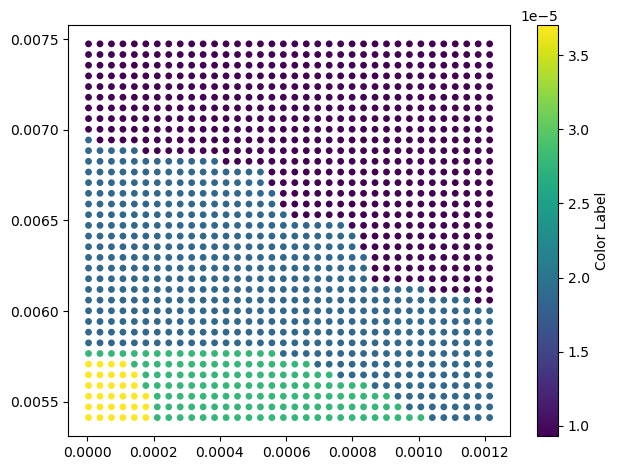

In [4]:
plot_PC_2d(nearest_36)

In [5]:
extract_dimensions(nearest_36)

{'length': 0.0012117038103774196,
 'width': 0.0020609366313237955,
 'height': 2.7744561994466938e-05}

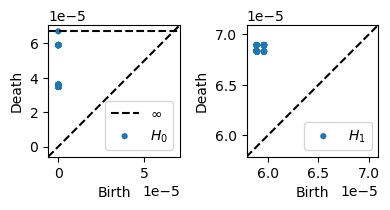

In [6]:
afm_dgms = ripser.ripser(nearest_36)['dgms']

plot_diagrams(afm_dgms, plot_only=[0], ax=plt.subplot(121))
plot_diagrams(afm_dgms, plot_only=[1], ax=plt.subplot(122))

#### Paracetamol - CG

In [7]:
crystal_edit = read_XYZ('/Users/user/Documents/PhD/AFML/test_sims/PAR_ETH_100_BIG/XYZ_files/PAR_ETH_100_1_ovito_CGvisualiser_unscaled.XYZ')
crystal_edit = order_z(crystal_edit)

In [8]:
crystal = remove_z_levels(crystal_edit, [6.,4.,2.])
crystal = crystal[:, 1:]

crystal = cut_out(crystal, 500, -150, 400)
#plot_PC_2d(crystal)
#print(crystal[:25])

In [9]:
extract_dimensions(crystal)

{'length': 397.791, 'width': 387.43399999999997, 'height': 23.298999999999978}

In [62]:
# working
def voxelization(points, resolution):
    # Extract columns
    xs = points[:, 0]
    ys = points[:, 1]
    zs = points[:, 2]
    
    # Calculate voxel sizes based on resolution and the range of points in x and y
    x_voxel_size = (xs.max() - xs.min()) / resolution
    y_voxel_size = (ys.max() - ys.min()) / resolution
    
    # For voxelization, we'll floor-divide by voxel size and multiply again.
    # This will ensure points falling in the same voxel get the same coordinates.
    voxelized_xs = np.floor(xs / x_voxel_size) * x_voxel_size + x_voxel_size / 2
    voxelized_ys = np.floor(ys / y_voxel_size) * y_voxel_size + y_voxel_size / 2
    
    # Group by voxelized (X, Y) and Z, then calculate the mean for each group
    voxel_points = {}
    for x, y, z in zip(voxelized_xs, voxelized_ys, zs):
        if (x, y, z) not in voxel_points:
            voxel_points[(x, y, z)] = []
        voxel_points[(x, y, z)].append((x, y, z))
    
    # Now, for each voxel, we'll average the points (should be near identical due to voxelization)
    centroids = []
    for k, pts in voxel_points.items():
        avg_x = np.mean([p[0] for p in pts])
        avg_y = np.mean([p[1] for p in pts])
        centroids.append([avg_x, avg_y, k[2]])  # Z is preserved
        
    return np.array(centroids)

def voxelisation_expand_bound_half_offset(points, resolution):
    xs, ys, zs = points[:, 0], points[:, 1], points[:, 2]
    
    # Compute voxel size in x and y based on desired dimensions
    voxel_size_x = (xs.max() - xs.min()) / resolution
    voxel_size_y = (ys.max() - ys.min()) / resolution

    # Expand boundaries by half a voxel size
    xs = xs + voxel_size_x / 2
    ys = ys + voxel_size_y / 2
    
    # Now, perform the voxelization using the adjusted coordinates
    voxelized_xs = np.floor(xs / voxel_size_x) * voxel_size_x + voxel_size_x / 2
    voxelized_ys = np.floor(ys / voxel_size_y) * voxel_size_y + voxel_size_y / 2
    
    # Combine voxels based on average if they occupy the same position
    voxel_points = {}
    for x, y, z in zip(voxelized_xs, voxelized_ys, zs):
        if (x, y, z) not in voxel_points:
            voxel_points[(x, y, z)] = []
        voxel_points[(x, y, z)].append((x, y, z))

    centroids = []
    for k, pts in voxel_points.items():
        avg_x = np.mean([p[0] for p in pts])
        avg_y = np.mean([p[1] for p in pts])
        centroids.append([avg_x, avg_y, k[2]])
        
    return np.array(centroids)

def voxelisation_edge_fill(points, resolution):
    xs, ys, zs = points[:, 0], points[:, 1], points[:, 2]
    
    # Compute voxel size in x and y based on desired dimensions
    voxel_size_x = (xs.max() - xs.min()) / resolution
    voxel_size_y = (ys.max() - ys.min()) / resolution
    
    # Voxelization
    voxelized_xs = np.floor(xs / voxel_size_x) * voxel_size_x + voxel_size_x / 2
    voxelized_ys = np.floor(ys / voxel_size_y) * voxel_size_y + voxel_size_y / 2
    
    # Combine voxels based on average if they occupy the same position
    voxel_points = {}
    for x, y, z in zip(voxelized_xs, voxelized_ys, zs):
        if (x, y, z) not in voxel_points:
            voxel_points[(x, y, z)] = []
        voxel_points[(x, y, z)].append((x, y, z))

    centroids = []
    for k, pts in voxel_points.items():
        avg_x = np.mean([p[0] for p in pts])
        avg_y = np.mean([p[1] for p in pts])
        centroids.append([avg_x, avg_y, k[2]])

    # Edge filling
    filled_points = set()
    for pt in centroids:
        filled_points.add((pt[0], pt[1], pt[2]))
    
    min_x, min_y, max_x, max_y = xs.min(), ys.min(), xs.max(), ys.max()
    z_levels = sorted(set(zs))

    # Loop over all possible edge voxels and fill if they're empty
    for z in z_levels:
        for x in [min_x, max_x]:
            for y in np.arange(min_y, max_y + voxel_size_y, voxel_size_y):
                if (x, y, z) not in filled_points:
                    centroids.append([x, y, z])
        for y in [min_y, max_y]:
            for x in np.arange(min_x, max_x + voxel_size_x, voxel_size_x):
                if (x, y, z) not in filled_points:
                    centroids.append([x, y, z])

    return np.array(centroids)

def voxelisation_edge_fill_z(points, resolution):
    xs, ys, zs = points[:, 0], points[:, 1], points[:, 2]
    
    # Compute voxel size in x and y based on desired dimensions
    voxel_size_x = (xs.max() - xs.min()) / resolution
    voxel_size_y = (ys.max() - ys.min()) / resolution
    
    # Voxelization
    voxelized_xs = np.floor(xs / voxel_size_x) * voxel_size_x + voxel_size_x / 2
    voxelized_ys = np.floor(ys / voxel_size_y) * voxel_size_y + voxel_size_y / 2
    
    # Combine voxels based on average if they occupy the same position
    voxel_points = {}
    for x, y, z in zip(voxelized_xs, voxelized_ys, zs):
        if (x, y, z) not in voxel_points:
            voxel_points[(x, y, z)] = []
        voxel_points[(x, y, z)].append((x, y, z))

    centroids = []
    for k, pts in voxel_points.items():
        avg_x = np.mean([p[0] for p in pts])
        avg_y = np.mean([p[1] for p in pts])
        centroids.append([avg_x, avg_y, k[2]])

    filled_points = set()
    for pt in centroids:
        filled_points.add((pt[0], pt[1], pt[2]))

    z_levels = sorted(set(zs))
    min_x, max_x = xs.min(), xs.max()
    min_y, max_y = ys.min(), ys.max()

    # Check the boundaries for each z-level
    for z in z_levels:
        # Check in X direction
        for y in np.arange(min_y, max_y + voxel_size_y, voxel_size_y):
            for x in [min_x, max_x]:
                if (x, y, z) not in filled_points:
                    # Check if adjacent voxels exist
                    neighbors = [(x + voxel_size_x, y, z), (x - voxel_size_x, y, z)]
                    if any(neighbor in filled_points for neighbor in neighbors):
                        centroids.append([x, y, z])

        # Check in Y direction
        for x in np.arange(min_x, max_x + voxel_size_x, voxel_size_x):
            for y in [min_y, max_y]:
                if (x, y, z) not in filled_points:
                    # Check if adjacent voxels exist
                    neighbors = [(x, y + voxel_size_y, z), (x, y - voxel_size_y, z)]
                    if any(neighbor in filled_points for neighbor in neighbors):
                        centroids.append([x, y, z])

    return np.array(centroids)

def voxelisation_boundary_fill(points, resolution):
    xs = points[:, 0]
    ys = points[:, 1]
    zs = points[:, 2]

    # Compute voxel size
    voxel_size_x = (xs.max() - xs.min()) / resolution
    voxel_size_y = (ys.max() - ys.min()) / resolution

    # Voxel assignment
    voxelized_xs = (xs / voxel_size_x).astype(int) * voxel_size_x + voxel_size_x / 2
    voxelized_ys = (ys / voxel_size_y).astype(int) * voxel_size_y + voxel_size_y / 2

    voxelized_points = np.array(list(zip(voxelized_xs, voxelized_ys, zs)))

    # Process by unique z-levels
    unique_z_levels = np.unique(zs)
    all_filled_points = []
    for z_level in unique_z_levels:
        z_points = voxelized_points[voxelized_points[:, 2] == z_level]

        # Check boundary cells and fill
        for x in [xs.min(), xs.max() - voxel_size_x]:  # left and right boundaries
            for y in np.arange(ys.min(), ys.max(), voxel_size_y):
                if not any((z_points[:, 0] == x) & (z_points[:, 1] == y)):
                    # Check neighbors
                    neighbors = [[x + voxel_size_x, y], [x - voxel_size_x, y], [x, y + voxel_size_y], [x, y - voxel_size_y]]
                    for nx, ny in neighbors:
                        if any((z_points[:, 0] == nx) & (z_points[:, 1] == ny)):
                            z_points = np.vstack([z_points, [x, y, z_level]])
                            break  # Only add one point per missing boundary voxel

        for y in [ys.min(), ys.max() - voxel_size_y]:  # top and bottom boundaries
            for x in np.arange(xs.min(), xs.max(), voxel_size_x):
                if not any((z_points[:, 0] == x) & (z_points[:, 1] == y)):
                    # Check neighbors
                    neighbors = [[x, y + voxel_size_y], [x, y - voxel_size_y], [x + voxel_size_x, y], [x - voxel_size_x, y]]
                    for nx, ny in neighbors:
                        if any((z_points[:, 0] == nx) & (z_points[:, 1] == ny)):
                            z_points = np.vstack([z_points, [x, y, z_level]])
                            break  # Only add one point per missing boundary voxel

        all_filled_points.append(z_points)

    return np.vstack(all_filled_points)

def voxelization_with_boundary_fill(points, resolution):
    # Extract columns
    xs = points[:, 0]
    ys = points[:, 1]
    zs = points[:, 2]
    
    # Compute voxel sizes
    voxel_size_x = (xs.max() - xs.min()) / resolution
    voxel_size_y = (ys.max() - ys.min()) / resolution

    # Voxelization
    voxelized_xs = np.floor(xs / voxel_size_x) * voxel_size_x + voxel_size_x / 2
    voxelized_ys = np.floor(ys / voxel_size_y) * voxel_size_y + voxel_size_y / 2

    # Convert to voxel coordinates (this will help us identify neighbors easily)
    voxel_coords = np.column_stack([
        (voxelized_xs - xs.min()) / voxel_size_x,
        (voxelized_ys - ys.min()) / voxel_size_y,
        zs
    ]).astype(int)

    # Convert to a dictionary for quick membership checking
    voxel_dict = {(x, y, z) for x, y, z in voxel_coords}

    # Function to check if a voxel exists in our set
    def voxel_exists(x, y, z):
        return (x, y, z) in voxel_dict

    # Boundary fill
    for z in np.unique(zs):
        for x in range(resolution):
            for y in [0, resolution - 1]:  # top and bottom boundaries
                if not voxel_exists(x, y, int(z)):
                    # Check neighbors (in the Y direction since we're at top/bottom boundaries)
                    if voxel_exists(x, y-1, int(z)) or voxel_exists(x, y+1, int(z)):
                        voxel_dict.add((x, y, int(z)))

        for y in range(resolution):
            for x in [0, resolution - 1]:  # left and right boundaries
                if not voxel_exists(x, y, int(z)):
                    # Check neighbors (in the X direction since we're at left/right boundaries)
                    if voxel_exists(x-1, y, int(z)) or voxel_exists(x+1, y, int(z)):
                        voxel_dict.add((x, y, int(z)))

    # Convert back to original coordinates for the result
    filled_voxels = np.array([[x * voxel_size_x + xs.min(), 
                               y * voxel_size_y + ys.min(), 
                               z] for x, y, z in voxel_dict])

    return filled_voxels

def fill_boundary_voxels(voxelized_data, resolution):
    # Extracted voxel sizes based on desired resolution and point cloud dimensions
    x_min, x_max = np.min(voxelized_data[:, 0]), np.max(voxelized_data[:, 0])
    y_min, y_max = np.min(voxelized_data[:, 1]), np.max(voxelized_data[:, 1])
    z_min, z_max = np.min(voxelized_data[:, 2]), np.max(voxelized_data[:, 2])
    
    voxel_size_x = (x_max - x_min) / resolution
    voxel_size_y = (y_max - y_min) / resolution

    # Set to quickly check existence of a voxel
    voxel_set = set(map(tuple, voxelized_data))

    # Check the x boundaries
    for y in np.arange(y_min, y_max + voxel_size_y, voxel_size_y):
        for z in np.arange(z_min, z_max + 1):
            if (x_min, y, z) not in voxel_set:
                voxel_set.add((x_min, y, z))
            if (x_max, y, z) not in voxel_set:
                voxel_set.add((x_max, y, z))

    # Check the y boundaries
    for x in np.arange(x_min, x_max + voxel_size_x, voxel_size_x):
        for z in np.arange(z_min, z_max + 1):
            if (x, y_min, z) not in voxel_set:
                voxel_set.add((x, y_min, z))
            if (x, y_max, z) not in voxel_set:
                voxel_set.add((x, y_max, z))

    # Convert set back to array
    filled_data = np.array(list(voxel_set))

    return filled_data

def fill_boundary_voxels_v2(voxelized_data, resolution=32):
    # 1. Construct a 2D array
    z_map = -np.ones((resolution, resolution), dtype=int)
    
    # 2. Populate the 2D array with z-values from voxelized data
    for x, y, z in voxelized_data:
        z_map[int(x), int(y)] = int(z)
    
    # 3. Inspect the boundaries of the 2D array
    def nearest_z_neighbor(i, j, z_map):
        neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
        for ni, nj in neighbors:
            if 0 <= ni < resolution and 0 <= nj < resolution and z_map[ni, nj] != -1:
                return z_map[ni, nj]
        return -1  # No neighbor found
    
    for i in range(resolution):
        for j in [0, resolution-1]:  # Top and bottom rows
            if z_map[i, j] == -1:
                z_map[i, j] = nearest_z_neighbor(i, j, z_map)
                
        for j in range(resolution):
            for i in [0, resolution-1]:  # Left and right columns
                if z_map[i, j] == -1:
                    z_map[i, j] = nearest_z_neighbor(i, j, z_map)
    
    # Convert the 2D map back to point cloud data
    filled_data = []
    for x in range(resolution):
        for y in range(resolution):
            if z_map[x, y] != -1:
                filled_data.append([x, y, z_map[x, y]])
                
    return np.array(filled_data)

def fill_missing_voxels(data, m, n):
    # Convert each numpy ndarray entry in data to a tuple
    tuple_data = [tuple(point) for point in data]
    # Convert data list to a set for faster look-up
    data_set = set(tuple_data)
    
    # Helper function to check if a voxel is occupied
    def is_filled(x, y, z):
        return (x, y, z) in data_set

    # Define all boundary voxels
    boundary_voxels = {(x, y): True for x in [0, m-1] for y in range(m)}
    boundary_voxels.update({(x, y): True for y in [0, m-1] for x in range(m)})

    # Iterate over z levels
    for z in range(1, n+1):
        for (x, y) in list(boundary_voxels.keys()):
            # Check if this boundary voxel is filled at any z-level
            filled_at_any_z = any(is_filled(x, y, z_i) for z_i in range(1, n+1))
            
            if not filled_at_any_z:
                # Check adjacent points in x and y
                adjacent_filled = any([
                    (x > 0 and is_filled(x-1, y, z)),
                    (x < m-1 and is_filled(x+1, y, z)),
                    (y > 0 and is_filled(x, y-1, z)),
                    (y < m-1 and is_filled(x, y+1, z))
                ])
                # Check if a filled voxel exists at the boundary position for some higher z-level
                filled_at_higher_z = any(is_filled(x, y, z_i) for z_i in range(z+1, n+1))
                
                if adjacent_filled and filled_at_higher_z:
                    data_set.add((x, y, z))
                    boundary_voxels.pop((x, y))

    # Convert the filled set back to a numpy array
    filled_data_array = np.array(list(data_set))
    return filled_data_array


# working
def adjacent_z_wipe(voxelized_points):
    """
    For voxels with the same (x, y) but adjacent z-levels, remove the one at the lower z-level.
    """
    
    # Create a dictionary to track voxel positions
    voxel_dict = {(x, y): z for x, y, z in voxelized_points}
    
    # Iterate over the voxelized_points to identify conflicts
    to_remove = set()
    for x, y, z in voxelized_points:
        if (x, y, z + 1) in voxel_dict:  # Check if there's a voxel directly above the current voxel
            to_remove.add((x, y, z))
    
    # Remove the identified conflicting points
    cleaned_points = np.array([point for point in voxelized_points if (point[0], point[1], point[2]) not in to_remove])
    
    return cleaned_points

# working
def scale_point_cloud(points, x_range=32, y_range=32):
    """
    Scale the given point cloud's x and y to the specified range. 
    The z-coordinates will be remapped to integer values from 1 to number of unique z-values.
    
    Parameters:
    - points (list of tuples or np.array): The point cloud in format [(x1,y1,z1), (x2,y2,z2), ...]
    - x_range (int): The maximum value for x after scaling.
    - y_range (int): The maximum value for y after scaling.
    
    Returns:
    - Scaled point cloud as a numpy array with shape (n, 3), where n is the number of points.
    """
    
    points = np.array(points)  # Convert to numpy array if not already
    
    # Compute the scaling factors and shifts for x and y
    x_shift = np.min(points[:, 0])
    y_shift = np.min(points[:, 1])
    x_scale = x_range / (np.max(points[:, 0]) - x_shift)
    y_scale = y_range / (np.max(points[:, 1]) - y_shift)
    
    # Scale and shift the x and y coordinates
    points[:, 0] = (points[:, 0] - x_shift) * x_scale
    points[:, 1] = (points[:, 1] - y_shift) * y_scale
    
    # Create a mapping from each unique z-value to an integer starting from 1
    unique_z_vals = np.unique(points[:, 2])
    z_mapping = {val: idx+1 for idx, val in enumerate(sorted(unique_z_vals))}
    
    # Replace z-values with their corresponding integer value
    for idx, row in enumerate(points):
        points[idx, 2] = z_mapping[row[2]]
    
    return points



[[ 863.95232813  223.98528125  569.554     ]
 [ 863.95232813 -139.23409375  569.554     ]
 [ 876.38329687  236.09259375  569.554     ]
 ...
 [ 503.45423437    6.05365625  592.853     ]
 [ 540.74714062   66.59021875  592.853     ]
 [ 540.74714062   18.16096875  592.853     ]]
[[29. 30.  1.]
 [29.  0.  1.]
 [30. 31.  1.]
 ...
 [ 0. 12.  5.]
 [ 3. 17.  5.]
 [ 3. 13.  5.]]
[[19. 16.  3.]
 [20. 13.  3.]
 [ 6. 13.  4.]
 ...
 [29. 27.  2.]
 [13. 17.  4.]
 [ 7.  6.  3.]]


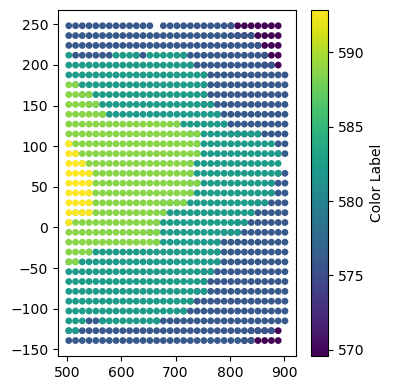

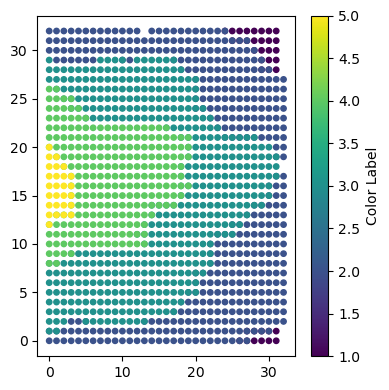

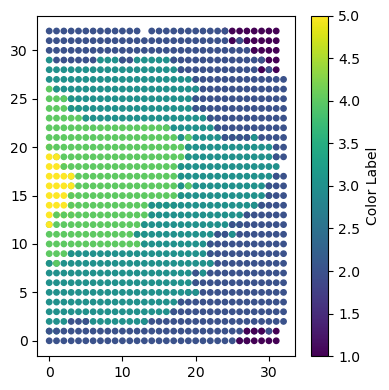

In [64]:
crystal_voxel32 = voxelization(crystal, 32)
#crystal_voxel32_2 = voxelisation_expand_bound_half_offset(crystal, 32)
#crystal_voxel32_4 = voxelisation_edge_fill_z(crystal, 32)
#crystal_voxel32_3 = voxelisation_edge_fill(crystal, 32)
#crystal_voxel32_5 = voxelisation_boundary_fill(crystal, 32)
#crystal_voxel32_6 = voxelization_with_boundary_fill(crystal, 32)

crystal_voxel32norm = scale_point_cloud(crystal_voxel32)

print(crystal_voxel32)
print(crystal_voxel32norm)

#crystal_voxel32boundary = fill_boundary_voxels_v2(crystal_voxel32)

#crystal_voxel32wipe = adjacent_z_wipe(crystal_voxel32boundary)

#plot_PC_2d(crystal)
#plot_PC_2d(crystal_voxel32)
#plot_PC_2d(crystal_voxel32boundary)
#plot_PC_2d(crystal_voxel32wipe)

crystal_voxel32fill = fill_missing_voxels(crystal_voxel32norm, 32, 5)

print(crystal_voxel32fill)

plot_PC_2d(crystal_voxel32)
plot_PC_2d(crystal_voxel32norm)
plot_PC_2d(crystal_voxel32fill)

methodology isn't working - we should manually fill in boundary pixels after voxelising

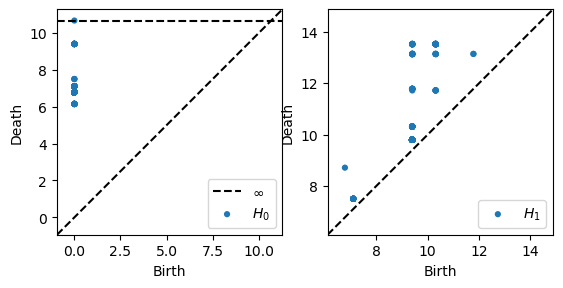

In [ ]:
CG_dgms = ripser.ripser(crystal)['dgms']

plot_diagrams(CG_dgms, plot_only=[0], ax=plt.subplot(121))
plot_diagrams(CG_dgms, plot_only=[1], ax=plt.subplot(122))

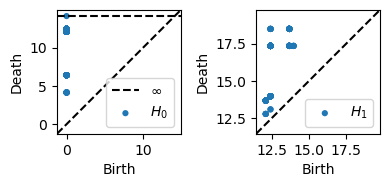

In [ ]:
CG_dgms_voxel = ripser.ripser(crystal_voxel32wipe)['dgms']

plot_diagrams(CG_dgms_voxel, plot_only=[0], ax=plt.subplot(121))
plot_diagrams(CG_dgms_voxel, plot_only=[1], ax=plt.subplot(122))